In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from utils.data import load_tc_data
from utils.plot import make_cmap
import cftime as cf
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from netCDF4 import Dataset
from numpy import inf
from scipy.stats import gaussian_kde

In [2]:
disc_pred = np.load('/user/home/al18709/work/gan_predictions_20/validation_disc_pred-opt_modular_part2_raw.npy')
gen_pred = np.load('/user/home/al18709/work/gan_predictions_20/validation_pred-opt_modular_part2_raw.npy')
inputs = np.load('/user/work/al18709/tc_data_flipped/KE_tracks/valid_X.npy')

In [3]:
print(disc_pred.shape)
print(inputs.shape)

(15930, 1, 20)
(15930, 6)


In [4]:
print(disc_pred[10,0,2])

17.025676727294922


/tmp/ipykernel_47250/690741997.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(disc_pred[:,0,0], shade=True, color="#3E579C")


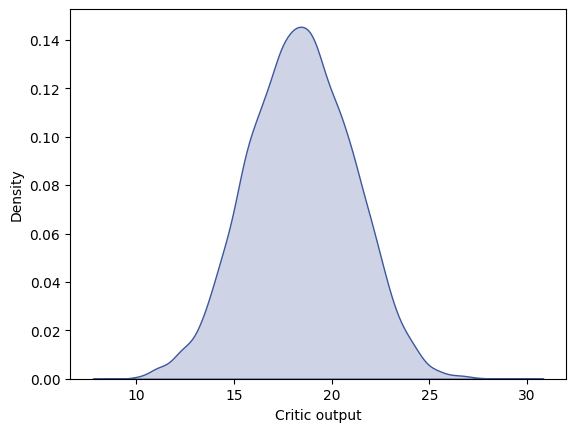

In [5]:
# sns.set_style("whitegrid")  # You can change the style to your preference
sns.kdeplot(disc_pred[:,0,0], shade=True, color="#3E579C")
# plt.title("Kernel Density Estimation (KDE) Plot")
plt.xlabel("Critic output")
plt.ylabel("Density")
plt.show()

In [6]:
percentiles = np.arange(0,100,10)
pred_p = np.percentile(disc_pred[:,0,0], percentiles)
min = np.min(disc_pred[:,0,0])
max = np.max(disc_pred[:,0,0])
limits = [0] * 10
limits[-1] = max
limits[0:-1] = pred_p

In [7]:
print(pred_p)
print(limits)

[ 8.92525864 14.96593647 16.0939621  16.95206013 17.69553413 18.38889217
 19.06957703 19.8239563  20.69867058 21.85323524]
[8.92525863647461, 14.965936470031739, 16.093962097167967, 16.9520601272583, 17.69553413391113, 18.38889217376709, 19.069577026367188, 19.823956298828126, 20.69867057800293, 21.853235244750977, 29.681215286254883]


In [8]:

p_10 = inputs[(disc_pred[:,0,0] > limits[0]) & (disc_pred[:,0,0] < limits[1]),:]
p_20 = inputs[(disc_pred[:,0,0] > limits[1]) & (disc_pred[:,0,0] < limits[2]),:]
p_30 = inputs[(disc_pred[:,0,0] > limits[2]) & (disc_pred[:,0,0] < limits[3]),:]
p_40 = inputs[(disc_pred[:,0,0] > limits[3]) & (disc_pred[:,0,0] < limits[4]),:]
p_50 = inputs[(disc_pred[:,0,0] > limits[4]) & (disc_pred[:,0,0] < limits[5]),:]
p_60 = inputs[(disc_pred[:,0,0] > limits[5]) & (disc_pred[:,0,0] < limits[6]),:]
p_70 = inputs[(disc_pred[:,0,0] > limits[6]) & (disc_pred[:,0,0] < limits[7]),:]
p_80 = inputs[(disc_pred[:,0,0] > limits[7]) & (disc_pred[:,0,0] < limits[8]),:]
p_90 = inputs[(disc_pred[:,0,0] > limits[8]) & (disc_pred[:,0,0] < limits[9]),:]
p_100 = inputs[(disc_pred[:,0,0] > limits[9]) & (disc_pred[:,0,0] < limits[10]),:]


[7.2296591e-05]
[7.25080023e-05 7.84192704e-05 8.73891337e-05 1.05830998e-04
 1.41053777e-04 1.99430121e-04 2.84835761e-04 3.98194150e-04
 5.38662285e-04 7.06288845e-04 9.05049837e-04 1.14447170e-03
 1.43812643e-03 1.79842132e-03 2.22907465e-03 2.71863434e-03
 3.23915678e-03 3.75273223e-03 4.22497178e-03 4.64042267e-03
 5.01268134e-03 5.38358094e-03 5.81079878e-03 6.34875046e-03
 7.03045521e-03 7.85689877e-03 8.79676958e-03 9.79591957e-03
 1.07938806e-02 1.17436478e-02 1.26296561e-02 1.34778186e-02
 1.43525455e-02 1.53401041e-02 1.65240868e-02 1.79632430e-02
 1.96809606e-02 2.16692028e-02 2.39018589e-02 2.63485758e-02
 2.89824036e-02 3.17802593e-02 3.47194306e-02 3.77738504e-02
 4.09125154e-02 4.41018345e-02 4.73135760e-02 5.05378638e-02
 5.37959087e-02 5.71435899e-02 6.06591338e-02 6.44161312e-02
 6.84518820e-02]
[ 8.92932741  9.04523702  9.16114662  9.27705622  9.39296583  9.50887543
  9.62478504  9.74069464  9.85660424  9.97251385 10.08842345 10.20433306
 10.32024266 10.43615226 10.

/tmp/ipykernel_47250/747367431.py:38: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(disc_pred[:,0,0], shade=False, color="#3E579C")


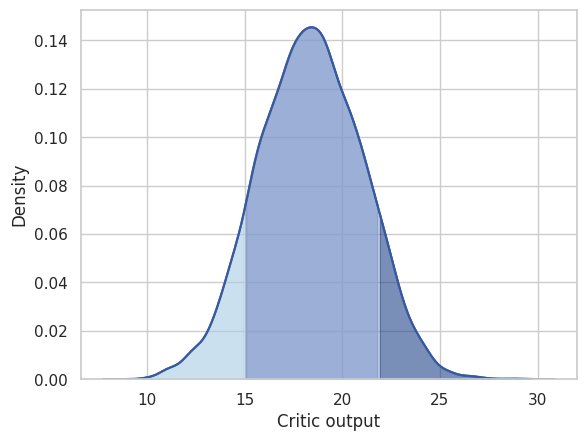

In [21]:
# sns.set_style("whitegrid")  # You can change the style to your preference
kde = gaussian_kde(disc_pred[:,0,0])


colours = ["#A8CCE3","#98B5D9","#89A0CF", "#799AC5", "#6A88BB", "#5B78B0","#4C67A6", "#3E579C","#2F4792","#204587","black"]
print(kde.evaluate(limits[0]))
x_kde, y_kde = sns.kdeplot(disc_pred[:,0,0]).get_lines()[0].get_data()

for i in range(10):
	if i in range(1,9):
		y = y_kde[(x_kde >= limits[1]) & (x_kde <= limits[9])]
		x = x_kde[(x_kde >= limits[1]) & (x_kde <= limits[9])]
		print(y)
		print(x)
		plt.fill_between(x,y, color=colours[2], alpha=0.2)
		continue
	[y1] = kde.evaluate(limits[i])
	[y2] = kde.evaluate(limits[i+1])
	y = y_kde[(x_kde >= limits[i]) & (x_kde <= limits[i+1])]
	x = x_kde[(x_kde >= limits[i]) & (x_kde <= limits[i+1])]
	print(y)
	print(x)
	plt.fill_between(x,y, color=colours[i], alpha=0.6)
	line1_x = limits[i]
	line2_x = limits[i+1]
	print(y1,y2)
	y2 = np.maximum(y1,y2)
	y1 = np.minimum(y1,y2)
	# plt.fill_betweenx([0,y2], line1_x, x2=line2_x, color=colours[i], alpha=0.6)
	# plt.plot([limits[i],limits[i]],[0,y1],color=colours[i],fill=True)


# [y_max] = kde.evaluate(np.mean(disc_pred[:,0,0]))


# plt.fill_betweenx(y_kde, x_kde, color='orange', alpha=0.4, label='Opposite Area')
# 
sns.kdeplot(disc_pred[:,0,0], shade=False, color="#3E579C")
# plt.title("Kernel Density Estimation (KDE) Plot")
plt.xlabel("Critic output")
plt.ylabel("Density")
plt.show()

In [10]:
print(p_10.shape)
print(p_100.shape)

(1592, 6)
(1592, 6)


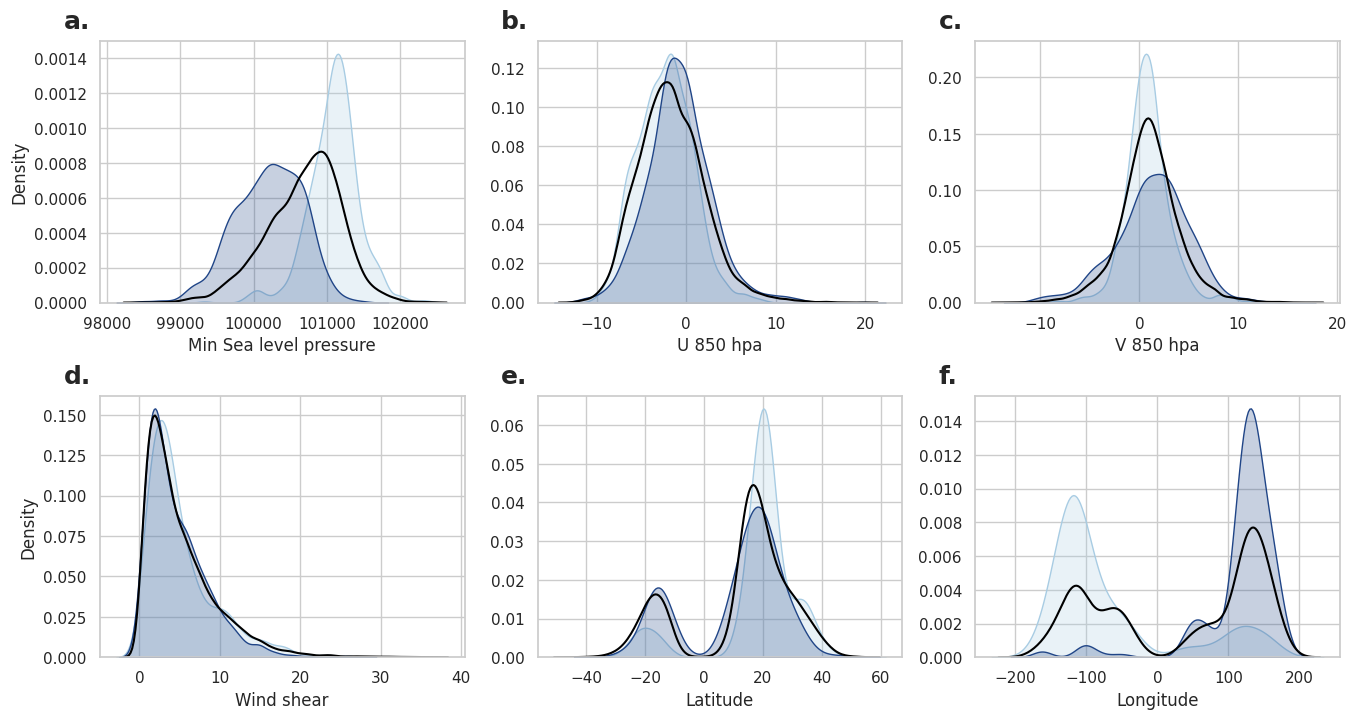

In [17]:
sns.set_style("whitegrid")  # You can change the style to your preference
height_ratios = [1,0.08,1]
fig, axes = plt.subplots(3, 3, figsize=(16, 8),gridspec_kw={'height_ratios': height_ratios})
titles = ['Min Sea level pressure', 'U 850 hpa', 'V 850 hpa', 'Wind shear', 'Latitude', 'Longitude']
labels = ['a.','b.','c.','d.','e.','f.']

for i in range(6):
    row, col = divmod(i, 3)
    
    if row == 1:
        # axes[row,col].set_facecolor('white')
        # axes[row,col] = 'off'
        axes[row,col].set_axis_off()
        row = 2
    sns.kdeplot(p_10[:,i], fill=True, color="#A8CCE3", ax=axes[row,col])
    # sns.kdeplot(p_20[:,i], fill=True, color="#98B5D9", ax=axes[row,col])
    # sns.kdeplot(p_30[:,i], fill=True, color="#89A0CF", ax=axes[row,col])
    # sns.kdeplot(p_40[:,i], fill=True, color="#799AC5", ax=axes[row,col])
    # sns.kdeplot(p_50[:,i], fill=True, color="#6A88BB", ax=axes[row,col])
    # sns.kdeplot(p_60[:,i], fill=True, color="#5B78B0", ax=axes[row,col])
    # sns.kdeplot(p_70[:,i], fill=True, color="#4C67A6", ax=axes[row,col])
    # sns.kdeplot(p_80[:,i], fill=True, color="#3E579C", ax=axes[row,col])
    # sns.kdeplot(p_90[:,i], fill=True, color="#2F4792", ax=axes[row,col])
    sns.kdeplot(p_100[:,i], fill=True, color="#204587", ax=axes[row,col])
    sns.kdeplot(inputs[:,i],fill=False, color="Black", ax=axes[row,col])
    axes[row,col].text(-0.1, 1.05, labels[i], transform=axes[row,col].transAxes, size=18, weight='bold')
    # axes[row,col].set_title(titles[i])
    axes[row,col].set_xlabel(titles[i])
    axes[row,col].set_ylabel("")
    
axes[0,0].set_ylabel('Density')
axes[2,0].set_ylabel('Density')
# plt.title("Kernel Density Estimation (KDE) Plot")
# plt.xlabel("Values")
# plt.ylabel("Density")
# plt.show()
plt.savefig('figure_9a_inputs.png',bbox_inches='tight',dpi=600)

In [12]:
pred_10 = gen_pred[(disc_pred[:,0,0] > limits[0]) & (disc_pred[:,0,0] < limits[1]),:,:]
pred_100 = gen_pred[(disc_pred[:,0,0] > limits[9]) & (disc_pred[:,0,0] < limits[10]),:,:]

In [13]:
# sns.set_style("white")
height_ratios = [1,0.01,1]
n = 3
m = 6
fig, axes = plt.subplots(n, m, figsize=(2*m + 0.5, 2*n), sharey=True,gridspec_kw={'height_ratios': height_ratios})


pal = sns.cubehelix_palette(10, rot=-.25, light=.7,as_cmap=True)

for i in range(m):
	for j in range(n):
		if j == 1:
			axes[j,i].set_axis_off()
			continue
		axes[j,i].set(xticklabels=[])
		axes[j,i].set(yticklabels=[])
		axes[j,i].spines['right'].set_color('#A9A9A9')  # Right spine color
		axes[j,i].spines['right'].set_linewidth(1) 
		axes[j,i].spines['left'].set_color('#A9A9A9')  # left spine color
		axes[j,i].spines['left'].set_linewidth(1)
		axes[j,i].spines['top'].set_color('#A9A9A9')  # top spine color
		axes[j,i].spines['top'].set_linewidth(1) 
		axes[j,i].spines['bottom'].set_color('#A9A9A9')  # bottom spine color
		axes[j,i].spines['bottom'].set_linewidth(1) 

		# axes[j,0].spines['bottom'].set_visible(False)
		# axes[j,0].spines['top'].set_visible(False)
		# axes[j,0].spines['left'].set_visible(False)
		# axes[j,0].spines['right'].set_visible(False)
		# axes[j,-1].spines['bottom'].set_visible(False)
		# axes[j,-1].spines['top'].set_visible(False)
		# axes[j,-1].spines['left'].set_visible(False)
		# axes[j,-1].spines['right'].set_visible(False)

# define cmap
precip_cmap,precip_norm = make_cmap()
norm = precip_norm

axes[0,0].text(-0.1, 1.05, 'a.', transform=axes[0,0].transAxes, size=16, weight='bold')
axes[2,0].text(-0.1, 1.05, 'b.', transform=axes[2,0].transAxes, size=16, weight='bold')

storms = np.random.randint(0,1000,6)
print(storms)
	
im = axes[0,0].imshow(pred_10[storms[0],:,:,0], interpolation='nearest', norm=norm,extent=None,cmap=precip_cmap)
axes[0,0].invert_yaxis()
axes[0,1].imshow(pred_10[storms[1],:,:,0], interpolation='nearest', norm=norm,extent=None,cmap=precip_cmap)
axes[0,1].invert_yaxis()
axes[0,2].imshow(pred_10[storms[2],:,:,0], interpolation='nearest', norm=norm,extent=None,cmap=precip_cmap)
axes[0,2].invert_yaxis()
axes[0,3].imshow(pred_10[storms[3],:,:,0], interpolation='nearest', norm=norm,extent=None,cmap=precip_cmap)
axes[0,3].invert_yaxis()
axes[0,4].imshow(pred_10[storms[4],:,:,0], interpolation='nearest', norm=norm,extent=None,cmap=precip_cmap)
axes[0,4].invert_yaxis()
axes[0,5].imshow(pred_10[storms[5],:,:,0], interpolation='nearest', norm=norm,extent=None,cmap=precip_cmap)
axes[0,5].invert_yaxis()

axes[2,0].imshow(pred_100[storms[0],:,:,0], interpolation='nearest', norm=norm,extent=None,cmap=precip_cmap)
axes[2,0].invert_yaxis()
axes[2,1].imshow(pred_100[storms[1],:,:,0], interpolation='nearest', norm=norm,extent=None,cmap=precip_cmap)
axes[2,1].invert_yaxis()
axes[2,2].imshow(pred_100[storms[2],:,:,0], interpolation='nearest', norm=norm,extent=None,cmap=precip_cmap)
axes[2,2].invert_yaxis()
axes[2,3].imshow(pred_100[storms[3],:,:,0], interpolation='nearest', norm=norm,extent=None,cmap=precip_cmap)
axes[2,3].invert_yaxis()
axes[2,4].imshow(pred_100[storms[4],:,:,0], interpolation='nearest', norm=norm,extent=None,cmap=precip_cmap)
axes[2,4].invert_yaxis()
axes[2,5].imshow(pred_100[storms[5],:,:,0], interpolation='nearest', norm=norm,extent=None,cmap=precip_cmap)
axes[2,5].invert_yaxis()





fig.subplots_adjust(right=0.8)
# cbar_ax = fig.add_axes([1, 0.15, 0.05, 0.7])
# cbar_ax = fig.add_axes([1, 0.031, 0.03, 0.936])
cbar_ax = fig.add_axes([1, 0.1, 0.02, 0.8])
# cbar_ax = fig.add_axes([0, -0.1, 1, 0.02])
levels=[0, 1, 2, 3, 5, 7, 10, 15, 20, 25, 30, 40, 50, 70, 100, 150]
cb = fig.colorbar(im, cax=cbar_ax,shrink=0.01,ticks=levels)
cb.ax.tick_params(labelsize=12)
cb.set_label('mm / 3hr', fontsize=16)
fig.tight_layout()

plt.savefig('figure_9b_examples.png',bbox_inches='tight',dpi=600)
plt.clf()


[400 153 399 991 747 705]


/tmp/ipykernel_47250/825105712.py:84: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


<Figure size 1250x600 with 0 Axes>

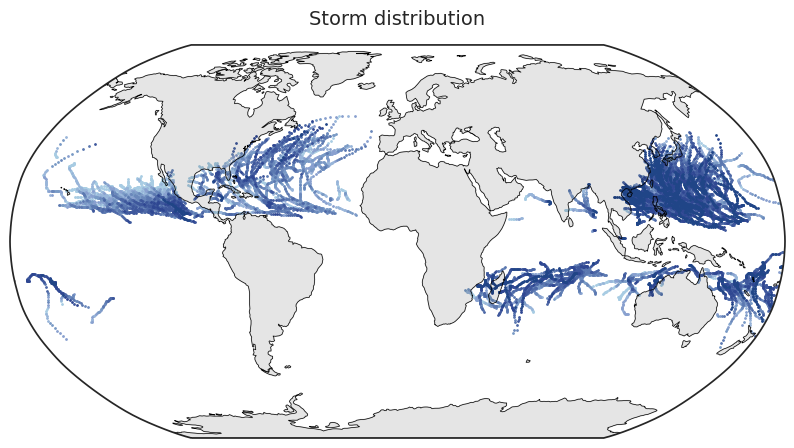

In [14]:
levels = [10, 15, 20, 25, 30, 40, 50,75, 100,140,180,200,250,300]
sns.set_style("white")
sns.set_context("notebook")
vmin=-2
vmax=2


fig, ax = plt.subplots(figsize=(10, 20),subplot_kw={'projection': ccrs.Robinson()})

# ax.set_xlim([-180, 180])
# ax.set_ylim([-90, 90])

ax.scatter(p_10[:,5],p_10[:,4], color="#A8CCE3",s=1,transform=ccrs.PlateCarree())
ax.scatter(p_20[:,5],p_20[:,4], color="#98B5D9",s=1,transform=ccrs.PlateCarree())
ax.scatter(p_30[:,5],p_30[:,4], color="#89A0CF",s=1,transform=ccrs.PlateCarree())
ax.scatter(p_40[:,5],p_40[:,4], color="#799AC5",s=1,transform=ccrs.PlateCarree())
ax.scatter(p_50[:,5],p_50[:,4], color="#6A88BB",s=1,transform=ccrs.PlateCarree())
ax.scatter(p_60[:,5],p_60[:,4], color="#5B78B0",s=1,transform=ccrs.PlateCarree())
ax.scatter(p_70[:,5],p_70[:,4], color="#4C67A6",s=1,transform=ccrs.PlateCarree())
ax.scatter(p_80[:,5],p_80[:,4], color="#3E579C",s=1,transform=ccrs.PlateCarree())
ax.scatter(p_90[:,5],p_90[:,4], color="#2F4792",s=1,transform=ccrs.PlateCarree())
ax.scatter(p_100[:,5],p_100[:,4], color="#204587",s=1,transform=ccrs.PlateCarree())

ax.add_feature(cfeature.COASTLINE,linewidth=0.5)
ax.add_feature(cfeature.LAND, zorder=100,color='black',alpha=0.1)


# plt.contourf(storm.precipitation[0,:,:,0],storm.storm_lats[0,:,:],storm.storm_lons[0,:,:])


# ax.outline_patch.set_linewidth(0.5)
# gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
# 			linewidth=0.5, color='gray', alpha=0.5, linestyle='-')
# gl.xlabels_top = False
# gl.ylabels_right = False
# gl.xlabel_style = {'size': 14}
# gl.ylabel_style = {'size': 14}

ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)


ax.set_title('Storm distribution',fontsize=14,pad=15)
ax.set_global()
plt.savefig('figure_9c_storm_distribution.png')

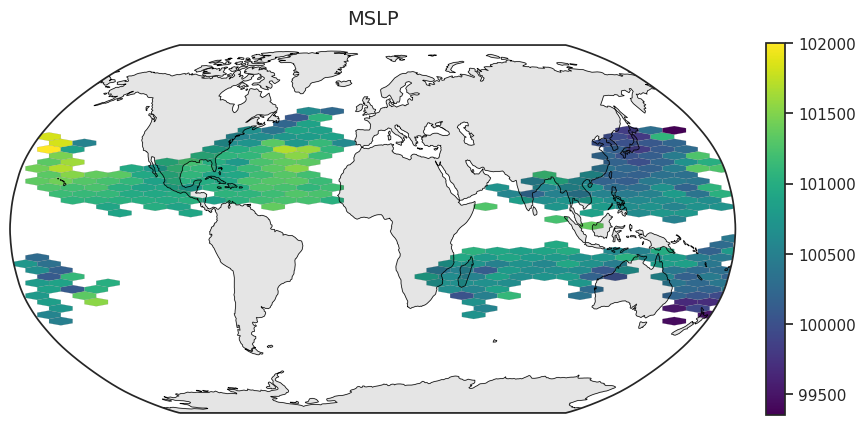

In [15]:
levels = [10, 15, 20, 25, 30, 40, 50,75, 100,140,180,200,250,300]
sns.set_style("white")
sns.set_context("notebook")
vmin=-2
vmax=2
width_ratios = [1,0.1]
fig, ax = plt.subplots(figsize=(10, 20),subplot_kw={'projection': ccrs.Robinson()})
# ax[1].set_axis_off()
# ax.contourf(inputs[:,5],inputs[:,4],inputs[:,0],levels=range(98000,102000,500000), transform=ccrs.PlateCarree(),cmap='Oranges')
# im = ax.pcolormesh(inputs[:,5],inputs[:,4],inputs[:,0], cmap='viridis', transform=ccrs.PlateCarree())
x = inputs[:,5]
y = inputs[:,4]
z = inputs[:,0]
m = ax.hexbin(x,y, C=z, gridsize=30, cmap='viridis', mincnt=1, edgecolor='gray', reduce_C_function=np.mean,linewidth=0.1, transform=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE,linewidth=0.5)
ax.add_feature(cfeature.LAND, zorder=100,color='black',alpha=0.1)
# gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
# 			linewidth=0.5, color='gray', alpha=0.5, linestyle='-')
# gl.xlabels_top = False
# gl.ylabels_right = False
# gl.xlabel_style = {'size': 14}
# gl.ylabel_style = {'size': 14}

ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)


ax.set_title('MSLP',fontsize=14,pad=15)
ax.set_global()
# cbar_ax = fig.add_axes([1, 0.031, 0.03, 0.936])
# levels=[0, 1, 2, 3, 5, 7, 10, 15, 20, 25, 30, 40, 50, 70, 100, 150]

cb = plt.colorbar(m,fraction=0.024, pad=0.04)

plt.savefig('figure_9d_mslp_distribution.png')